# Homework 2: Learning about Datasets

In [2]:
# Configure environment
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.stats as stats
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import pickle
import geopandas as gpd

In [3]:
# location of NEXDCP30 data
nexdcp_url="https://ds.nccs.nasa.gov/thredds/dodsC/bypass/NEX-DCP30/nex-quartile/rcp85/r1i1p1.ncml"


In [4]:
# open dataset using remote URL
max_temp_xr=xr.open_dataset(nexdcp_url)

# display dataset to see what it looks like
max_temp_xr

<xarray.Dataset>
Dimensions:            (lat: 3105, lon: 7025, bnds: 2, time: 1128)
Coordinates:
  * lat                (lat) float64 24.06 24.07 24.08 ... 49.91 49.92 49.93
  * lon                (lon) float64 235.0 235.0 235.0 ... 293.5 293.5 293.5
  * time               (time) datetime64[ns] 2006-01-16T12:00:00 ... 2099-12-...
Dimensions without coordinates: bnds
Data variables: (12/15)
    lat_bnds           (lat, bnds) float64 ...
    lon_bnds           (lon, bnds) float64 ...
    time_bnds          (time, bnds) float64 ...
    ens-avg_pr         (time, lat, lon) float32 ...
    ens-avg_tasmax     (time, lat, lon) float32 ...
    ens-avg_tasmin     (time, lat, lon) float32 ...
    ...                 ...
    quartile50_pr      (time, lat, lon) float32 ...
    quartile50_tasmax  (time, lat, lon) float32 ...
    quartile50_tasmin  (time, lat, lon) float32 ...
    quartile75_pr      (time, lat, lon) float32 ...
    quartile75_tasmax  (time, lat, lon) float32 ...
    quartile75_tasmin  (time, lat, lon) float32 ...
Attributes: (12/39)
    CDI:                            Climate Data Interface version 1.5.5 (htt...
    parent_experiment:              historical
    parent_experiment_id:           historical
    parent_experiment_rip:          r1i1p1
    creation_date:                  Mon Jul 23 02:05:29 PDT 2012
    CDO:                            Climate Data Operators version 1.5.5 (htt...
    ...                             ...
    title:                          800m Downscaled NEX CMIP5 Climate Project...
    contact:                        Dr. Rama Nemani: rama.nemani@nasa.gov, Dr...
    model_id:                       NEX-quartile
    references:                     BCSD method: Wood AW, Maurer EP, Kumar A,...
    DOI:                            http://dx.doi.org/10.7292/W0WD3XH4
    experiment:                     RCP8.5

In [5]:
sb_county = gpd.read_file('tl_2019_06083_faces/tl_2019_06083_faces.shp')

xmin, ymin, xmax, ymax = sb_county.total_bounds

In [6]:
xmin_shift = xmin + 360

In [7]:
xmax_shift = xmax + 360

In [8]:
# Create logical masks for lat and lon variables
mask_lon = (max_temp_xr.lon >= xmin) & (max_temp_xr.lon <= xmax)
mask_lat = (max_temp_xr.lat >= ymin) & (max_temp_xr.lat <= ymax)

In [9]:
# View first 5 latitude values
max_temp_xr["ens-avg_tasmax"]["lat"].values[:5]

print("The min and max latitude values in the data is:", 
      max_temp_xr["ens-avg_tasmax"]["lat"].values.min(), 
      max_temp_xr["ens-avg_tasmax"]["lat"].values.max())
print("The min and max longitude values in the data is:", 
      max_temp_xr["ens-avg_tasmax"]["lon"].values.min(), 
      max_temp_xr["ens-avg_tasmax"]["lon"].values.max())

The min and max latitude values in the data is: 24.0625 49.92916665632
The min and max longitude values in the data is: 234.97916666666998 293.51249997659


In [10]:
# View first 5 and last. 5 time values - notice the span of
# dates range from 1950 to 2005
print("The earliest date in the data is:", max_temp_xr["ens-avg_tasmax"]["time"].values.min())
print("The latest date in the data is:", max_temp_xr["ens-avg_tasmax"]["time"].values.max())    

The earliest date in the data is: 2006-01-16T12:00:00.000000000
The latest date in the data is: 2099-12-16T12:00:00.000000000


In [11]:
# Get lat min, max
aoi_lat = [float(sb_county.total_bounds[1]), float(sb_county.total_bounds[3])]
aoi_lon = [float(sb_county.total_bounds[0]), float(sb_county.total_bounds[2])]
# Notice that the longitude values have negative numbers
# we need these values in a global crs so we can subtract from 360
aoi_lat, aoi_lon

([33.411024, 35.114678], [-120.734382, -118.962728])

In [12]:
aoi_lon[0] = aoi_lon[0] + 360
aoi_lon[1] = aoi_lon[1] + 360
aoi_lon

[239.26561800000002, 241.037272]

In [13]:
# Slice the data by time and spatial extent
start_date = "2021-01-15"
end_date = "2021-02-15"

sb20 = max_temp_xr["ens-avg_tasmax"].sel(
    time=slice(start_date, end_date),
    lon=slice(aoi_lon[0], aoi_lon[1]),
    lat=slice(aoi_lat[0], aoi_lat[1]))
sb20

<xarray.DataArray 'ens-avg_tasmax' (time: 2, lat: 205, lon: 212)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [291.26614, 291.2615 , ..., 287.54147, 287.54123],
        [291.36923, 291.36426, ..., 287.54456, 287.54648]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [292.13806, 292.21265, ..., 291.53067, 291.4324 ],
        [292.2292 , 292.2218 , ..., 291.5333 , 291.43628]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 33.41 33.42 33.43 33.44 ... 35.09 35.1 35.1 35.11
  * lon      (lon) float64 239.3 239.3 239.3 239.3 ... 241.0 241.0 241.0 241.0
  * time     (time) datetime64[ns] 2021-01-16T12:00:00 2021-02-15
Attributes:
    associated_files:        baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLo...
    cell_methods:            time: maximum within days time: mean over days
    comment:                 monthly mean of the daily-maximum near-surface a...
    history:                 2012-03-23T08:59:58Z altered by CMOR: Treated sc...
    long_name:               Daily Maximum Near-Surface Air Temperature
    standard_name:           air_temperature
    computation:             ensemble mean
    original_ensemble_name:  ea
    units:                   K
    _ChunkSizes:             [  1 369 836]

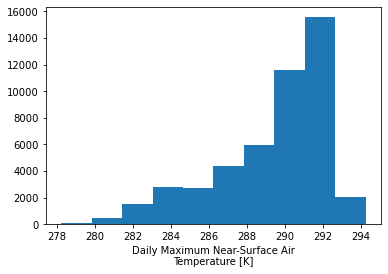

In [14]:
# Plot a quick histogram
sb20.plot()
plt.show()

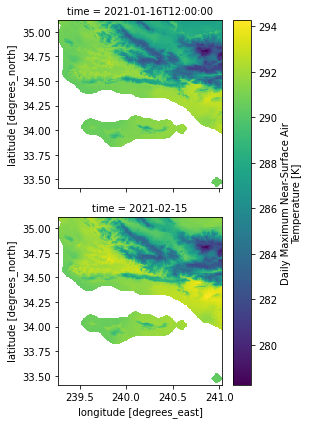

In [15]:
# Spatial Plot for the selected AOI (California)
sb20.plot(col='time',
                     col_wrap=1)

plt.show()

In [ ]:
# Create a spatial map of your selected location with cartopy
extent = [xmin, xmax, ymin, ymax]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),
                     subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location 
ax.plot(longitude-360, latitude, 
        'r*', 
        transform=ccrs.PlateCarree(),
       color="purple", markersize=10)

ax.set_extent(extent)
ax.set(title="Location of the Latitude / Longitude Being Used To to Slice Your netcdf Climate Data File")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

NameError: name 'longitude' is not defined

In [ ]:
# Apply lat/lon masks to the ERSST field, then calculate averages over the lat and lon dimensions
nex_sb=nex.where(mask_lon & mask_lat).mean("lon").mean("lat")

In [ ]:
# create a new figure, set size and resolution (dpi)
plt.figure(figsize=(10, 6), dpi=300)    
# add data to the plot
plt.plot(nex_sb.time,nex_sb.quartile25_tasmin)   
# Specify plot parameters
plt.title('Test', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('25th Tasmin', fontsize=14)

# NASA Earth Exchange (NEX) Downscaled Climate Projections (NEX-DCP30) dataset for the conterminous United States

## About the data
Modelled data generated from the General Circulation Model(GCM) runs under 33 different Coupled Model Intercomparison Project Phase 5(CMIP5) models. The modelled data projections are available for four greenhouse gas emissions scenarios known as Representative Concentration Pathways(RCPs)  labelled after the range of radiative forcing values in the year 2100 (2.6, 4.5, 6, and 8.5 W/m2).

## Data Access
Data can be download in a variety of ways at this link https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-dcp30 through the THREDDS Data Server.
For ease of use, our team used the NetcdfSubset method which allowed for input of desired consituents, geographic bounding box in latitude and longitude and time interval of interest. 

## Main constituents:
Precipitation (monthly mean of the daily precipitation rate)(kg/m2s)
Temperature (monthly mean of the daily predicted temperature)(deg K) 

## Data File Format: 
netcdf file
-one monthly averaged value for each month from 2006 to 2099
-monthly average can be based off of daily min, max, average and quartiles for each constituent
-your selected file will contain the variables you request for the spatial and temporal subset you specify in the NetcdfSubset access url 

## Metadata Format:
Since the data was in netcdf format, the metadata was contained within each downloaded file. The website source also provides a very useful Tech note which is accessed here: https://www.nccs.nasa.gov/sites/default/files/NEX-DCP30_Tech_Note.pdf





## 1. Write code to load in the dataset

## Loading Example Dataset 
Decided to focus on the RCP 8.5 dataset which is the most extreme emissions scenario for Santa Barbara area (9 cells centered on 34.4208° N, 119.6982° W). 

Downloaded Monthly Averages:
-Daily Mean Preciptation rate
-Daily Maximum Temperature
-Daily Minimum Temperature

In [2]:
# xarray was used to load in the data
sb_mean_precip = xr.open_dataset('sb_mean_precip_data.nc')
sb_mean_max_temp = xr.open_dataset('sb_mean_max_temp.nc')
sb_mean_min_temp = xr.open_dataset('sb_mean_min_temp.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/danielkerstan/Desktop/EDS_211/notebook/sb_mean_precip_data.nc'

In [ ]:
#view metadata
sb_mean_max_temp

## Date and Geospatial Format
Metadata indicates that date is in datetime64 format and geospatial information in stored as lat and lon(float64). 

# 2. Investigate data quality

## Spatial Coverage: 
Contiguous US at a spatial resolution of 30 arc-seconds/0.00833 degrees(approximately 800 meters)

## Temporal Coverage: 
Monthly average of 1950 through 2005 (“Retrospective Run”) and from 2006 to 2099 (“Prospective Run”)

The spatial and temporal coverage of this dataset are one of the key strength of the datsets. However, since it's modelled data, it comes with a set of assumptions. 

## Assumptions: 

Relative spatial patterns in temperature and precipitation observed from 1950 through 2005 will remain constant under future climate change. 

Does not add information beyond what is contained in the original CMIP5 scenarios, and preserves the frequency of periods of anomalously high and low temperature or precipitation (i.e., extreme events) within each individual CMIP5 scenario.

## Bias Correction-Spatial Disaggregation (BSCD)

***Problem: Biased data unsuitable for local level decision making.*** 

Original GCM model runs are run at coarse resolution which is not at the level of detail required for local decision making. In addition, although the projections are globally accurate there may be considerable bias at the local level since it does not take into account local topography.

***Solution: BSCD using PRISM (observational climate data from meteorological stations)***

The Bias-Correction step corrects the bias of the GCM data through comparisons performed against the observationally-based PRISM data.
The Spatial-Disaggregation step spatially interpolates the bias-corrected GCM data to the finer resolution grid of the 30-arc second PRISM data.

# 3. Consider appropriate use cases

The goal of this dataset is to “[Assist in] conducting studies of climate change impacts at local to regional scales, and to enhance public understanding of possible future climate patterns and climate impacts at the scale of individual neighborhoods and communities.”

This could be important for building and planning of cities, regions, or even individual neighborhoods.

Example use cases include: 

1. Watershed Management on a local level based on future precipitation trends

2. Building code updates based on projected changes in temperatures

3. Developing strategic plans for heatwaves, floods, wildfires and other natural disasters based on local level impacts 

The high spatial and temporal resolution allows for identification of detection of long-term trends on a local level. 

The monthly averaged data allows to identify potential increased risk to certain extreme events but not exact dates since that would not be feasible in modelling. 

Policymakers, think-tanks and business around the US regardless of their level can benefit from this dataset as they can limit their exposure to climate change risk based on these key indicators. 

Let’s take a closer look of our example for Santa Barbara:

In [ ]:
# store an object representing the time to use for the x-axis
sb_mean_precip_time = sb_mean_precip['time']

In [ ]:
# use groupby to get a single data value per time interval for the region of interest
sb_mean_precip_summary = sb_mean_precip.groupby('time').mean(['lat', 'lon'])

In [ ]:
# create a plot to show expected precipitation over the entire time period for the sb area
plt.figure(figsize = (10,6), dpi = 300)
plt.plot(sb_mean_precip_time, sb_mean_precip_summary['ens-avg_pr'])
plt.title("Monthly Average Precipitation")
plt.xlabel("Time")
plt.ylabel("Precipitation (kg m-2 s-1)")

In [ ]:
# establish a start date and end date to explore a more specific timeframe
start_date = np.datetime64('2021-10-31')
end_date = np.datetime64('2041-10-31')

# create a subset of the data that includes only this time period
sb_mean_precip_sub = sb_mean_precip["ens-avg_pr"].sel(time = slice(start_date, end_date))

In [ ]:
# store an object representing the time to use for the x-axis
sb_mean_precip_sub_time = sb_mean_precip_sub['time']

# use groupby to get a single data value per time interval for the region of interest
sb_mean_precip_sub_summary = sb_mean_precip_sub.groupby('time').mean(['lat', 'lon'])

In [ ]:
# plot this subset of the precipitation dataset
plt.figure(figsize = (10,6), dpi = 300)
plt.plot(sb_mean_precip_sub_time, sb_mean_precip_sub_summary)
plt.title("Monthly Average Precipitation")
plt.xlabel("Time")
plt.ylabel("Precipitation (kg m-2 s-1)")

In [ ]:
# repeat above steps to plot the maximum temperature data for the full time period
sb_mean_max_temp_time = sb_mean_max_temp['time']
sb_mean_max_temp_summary = sb_mean_max_temp.groupby('time').mean(['lat', 'lon'])
plt.figure(figsize = (10,6), dpi = 300)
plt.plot(sb_mean_max_temp_time, sb_mean_max_temp_summary['ens-avg_tasmax'])
plt.title("Monthly Average Maximum Near-Surface Air Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature (Degrees Kelvin)")

In [ ]:
# repeat above steps to plot the minimum temperature data for the full time period
sb_mean_min_temp_time = sb_mean_min_temp['time']
sb_mean_min_temp_summary = sb_mean_min_temp.groupby('time').mean(['lat', 'lon'])
plt.figure(figsize = (10,6), dpi = 300)
plt.plot(sb_mean_min_temp_time, sb_mean_min_temp_summary['ens-avg_tasmin'])
plt.title("Monthly Average Minimum Near-Surface Air Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature (Degrees Kelvin)")

# 4. Prepare dataset overview for class presentation

A short presentation was prepared for our class summarizing the results of the work above. The slides can be found here: https://docs.google.com/presentation/d/1gm9SebCXzmdPh4qMBduHCsOx_54i3758oSZKyAa5g7E/edit?usp=sharing

In [12]:
sb_county = gpd.read_file('tl_2019_06083_faces.shp')

xmin, ymin, xmax, ymax = sb_county.total_bounds

NameError: name 'gpd' is not defined